# Deep Learning Basics

We will work with a **feedforward neural network** (also known as a **multi-layer perceptron**) implemented solely in numpy, reflect on the associated details of the **forward** pass and implement the **backpropagation** parts of our layers to train our MLP. In Section 2, we will independently look at some gradient-based optimization techniques that are popular with convex functions and have been shown to be useful in finding sufficiently satisfactory optima on the loss manifolds on parametrized models. 


Review the details on the chain rule and the backproprapagation step. You should take a look at the guide we provide to get familiar with the forward pass and backward pass equations for a Multi-Layer Perceptron. 

* a **linear** layer with **Leaky ReLU** 
* a **linear** layer with a custom activation function that has a learnable parameter
* a **linear** output layer
* a **softmax cross-entropy** Loss layer 

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Feedforward Implementation with numpy

In [3]:
class Base:
    def __init__(self, input_dims:int, output_dims:int):
        self.input_dims = input_dims
        self.output_dims = output_dims

    def forward_pass(self):
        pass 
    
    def backward_pass(self):
        pass

    def update_weights(self, W, b, del_W, del_b, learning_rate):
        W-=(learning_rate*del_W)
        b-=(learning_rate*del_b)
        return W, b

class Hidden(Base):
    def __init__(self, input_dims:int, output_dims:int):
        super().__init__(input_dims, output_dims)
        
        self.W = np.random.random((input_dims, output_dims)) - 0.5
        self.c = np.random.random((1, output_dims)) - 0.5

    def forward_pass(self, X):
        U =X@ self.W + self.c
        activations= self.leaky_relu(U)
        return activations

    def backward_pass(self, X, h, dLdh, alpha, learning_rate):
        relu_derivative= self.leaky_relu_derivative(h)
        dLdU = np.multiply(relu_derivative, dLdh)
        dLdW = X.T @ dLdU + alpha * self.W
        dLdc = np.sum(dLdU, axis=0)
        for_prev =  dLdU @ self.W.T                                                        

        self.W, self.c = self.update_weights(self.W, self.c, dLdW, dLdc, learning_rate)
        return for_prev # Note: for_prev is the gradient dL/dh' we pass onto the previous layer h'

    def leaky_relu(self, inp):
        activation_mask = 1.0 * (inp >0) + 0.01*(inp<0)
        activations= np.multiply(inp, activation_mask)
        return activations 

    def leaky_relu_derivative(self, h):
        one_mask = h > 0
        slop_mask = 1 - one_mask
        leaky_relu_derivative = one_mask * 1 + slop_mask * 0.01
        return leaky_relu_derivative

class Hidden_Vondrick(Base):
    def __init__(self, input_dims:int, output_dims:int):
        super().__init__(input_dims, output_dims)
        
        self.W = np.random.random((input_dims, output_dims))
        self.c = np.random.random((1, output_dims))
        self.U= None
        self.vondrick_exponent= np.random.uniform(1.4,2) #The learnable exponent, called Vondrick Exponent, for our custom activation function is initilized from a Unifom(1.4,2) distribution. You may change this if you really want to, but keep it close to this range to ensure training stability.

        print("Intital Value of Vondrick Exponent: "+ str(self.vondrick_exponent) )

    def forward_pass(self, X):
        self.U =X@ self.W + self.c
        #Applys the custom activation elementwise
        activations= self.vondrick_activation(self.U)
        return activations

    def backward_pass(self, X, h, dLdh, alpha, learning_rate=0.0005):
    
        dhdU, dL_dexponent_scalar = self.vondrick_activation_derivative()
        dLdU = dLdh * dhdU
        dLdW = X.T @ dLdU + alpha * self.W
        dLdc = np.sum(dLdU, axis=0)
        for_prev = dLdU @ self.W.T

        #Note, that for the purposes of training stablity, we have hard-coded the learning rate here to be 0.0005
        self.W, self.c = self.update_weights(self.W, self.c, dLdW, dLdc, 0.0005) 

        #Gradient Descent on our learnable activation function parameter: Updating exponent, but clipping it's lower range to 1.01
        self.vondrick_exponent= max(1.01,self.vondrick_exponent- 0.001*dL_dexponent_scalar )

        return for_prev

    def vondrick_activation(self, U):
        one_mask = U > 0
        activations = (U ** self.vondrick_exponent) * one_mask + 0.01 * U * (1 - one_mask) 
        return activations 

    def vondrick_activation_derivative(self):
        one_mask = self.U > 0
        derivative_wrt_U = self.vondrick_exponent * (self.U ** (self.vondrick_exponent-1)) * one_mask + 0.01 * (1 - one_mask)
        derivative_wrt_exponent = np.sum(self.U[one_mask]**self.vondrick_exponent*np.log(self.U[one_mask])) # make sure log() defined
        return derivative_wrt_U, derivative_wrt_exponent

    
class Output(Base):

    def __init__(self, input_dims, output_dims):
        super().__init__(input_dims, output_dims)
        self.w = np.random.random((input_dims, output_dims)) -0.5
        self.b = np.random.random((1, output_dims)) -0.5

    def forward_pass(self, h):
        z = h @self.w + self.b
        z = z - np.max(z, axis = 1).reshape(z.shape[0], 1) # trick: subtracting maz z as softmax is not effected: prevents overflow when we do exponentation
        return z

    def backward_pass(self, h, dLdz, alpha, learning_rate):
        dLdw = h.T @ dLdz + alpha * self.w
        dLdb = np.sum(dLdz, axis=0)
        dLdh = dLdz @ self.w.T
        
        self.w, self.b = self.update_weights(self.w, self.b, dLdw, dLdb, learning_rate)
        return dLdh

class Loss(Base): 
    
    def __init__(self, input_dims, output_dims):
        super().__init__(input_dims, output_dims)
    
    def forward_pass(self, z, y):

        temp = -z + np.log(np.sum(np.exp(z), axis = 1)).reshape(z.shape[0], 1) #Computing Softmax Cross Entropy Loss terms for each z_i. Note dimensions of temp: batch_size x output layer output_dims
        L = temp[np.arange(z.shape[0]), y.flatten().astype(int)] #Extracts Loss term corresponding only to ground truth class from each row (sample). 
        L = np.mean(L) #Mean Loss over the batch
        return L 

    def backward_pass(self, z, y):
        #Recall the simplified expression we get for dL_i/dz_k= p_k- I(y_i=k) (Details in the guide)
        temp1 = np.zeros(z.shape)
        for i in range(z.shape[0]):
            true_class = int(y[i].item())
            temp1[i][true_class] = -1     #-1 is added to the loss term corresponding to the true class

        temp2 = np.exp(z)/ np.sum(np.exp(z), axis =1 ).reshape(z.shape[0], 1) #Matrik of p_k terms, aka, elements replaced by softmaxed probabilities
        for_previous = temp1 + temp2 
        return for_previous
    
class NN: 
    def __init__(self): 
        self.output_layer= self.loss_layer =  None 
        self.hidden_layers = []

    def add_layer(self, name, input_dims, output_dims):
        if name.lower() == 'hidden':
            self.hidden_layers.append(Hidden(input_dims, output_dims))
        elif name.lower() == 'hidden_vondrick':
            self.hidden_layers.append(Hidden_Vondrick(input_dims, output_dims))
        elif name.lower() =='output':
            self.output_layer = Output(input_dims, output_dims)
        elif name.lower() =='loss':
            self.loss_layer = Loss(input_dims, output_dims) 
    
    def forward_prop(self, X, y, alpha): 
        hidden_outputs = []
        z = L = h= None 
        for layer in self.hidden_layers:
            h = layer.forward_pass(X)
            hidden_outputs.append(h)
            X = h 
        z = self.output_layer.forward_pass(h)
        L = self.loss_layer.forward_pass(z, y)
        for layer in self.hidden_layers:
            L += 0.5*alpha*np.linalg.norm(layer.W)**2
        L+= 0.5*alpha* np.linalg.norm(self.output_layer.w)**2 
        return hidden_outputs, z, L 

    def backward_prop(self, X, hidden_outputs, z, y, alpha =0.01, learning_rate =0.01):
        dLdz = self.loss_layer.backward_pass(z, y)
        for_previous = self.output_layer.backward_pass(hidden_outputs[-1], dLdz, alpha, learning_rate) 
        for i in range(len(self.hidden_layers)-1,0,-1):
            temp = self.hidden_layers[i].backward_pass(hidden_outputs[i-1], hidden_outputs[i], for_previous, alpha, learning_rate)
            for_previous = temp 
        self.hidden_layers[0].backward_pass(X, hidden_outputs[0], for_previous, alpha, learning_rate)

    def train(self, X, y, epochs, batch_size, learning_rate, alpha, show_training_accuracy=True): 
  
        loss = []
        for epoch in range(epochs):
            predicted = self.predict(X)
            correct = 0 
            for i in range(len(predicted)):
                if predicted[i] == y[i]:
                    correct+=1
            if show_training_accuracy:
                print(f'the accuracy on the training data after epoch {epoch + 1} is {correct/X.shape[0]}')
            temp = total = 0 
            for k in range(0, X.shape[0], batch_size):
                inp = X[k:k+batch_size]
                out = y[k:k+batch_size]

                hidden_outputs, z, L = self.forward_prop(inp, out, alpha)
                temp+=L 
                total+=1
                self.backward_prop(inp, hidden_outputs, z, out, alpha, learning_rate)
            
            loss.append(temp/total)

        return loss

    def predict(self, X): 
        for f in self.hidden_layers:
          X = f.forward_pass(X)
        z = self.output_layer.forward_pass(X)
        predictions = np.argmax(z, axis=1)
        return predictions
    
    def compute_accuracy(self, X, Y):
        predicted_Y= self.predict(X)
        correct=0
        for i in range(len(predicted_Y)):
            if predicted_Y[i] == Y[i]:
                correct+=1
        return correct/len(Y)

def plot_loss(loss_li):
    #Given a list of losses over the epochs, plots the loss curve.
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("loss of the neural network per epoch")
    plt.plot(loss_li)
    plt.show()

## Gradient Calculation draft

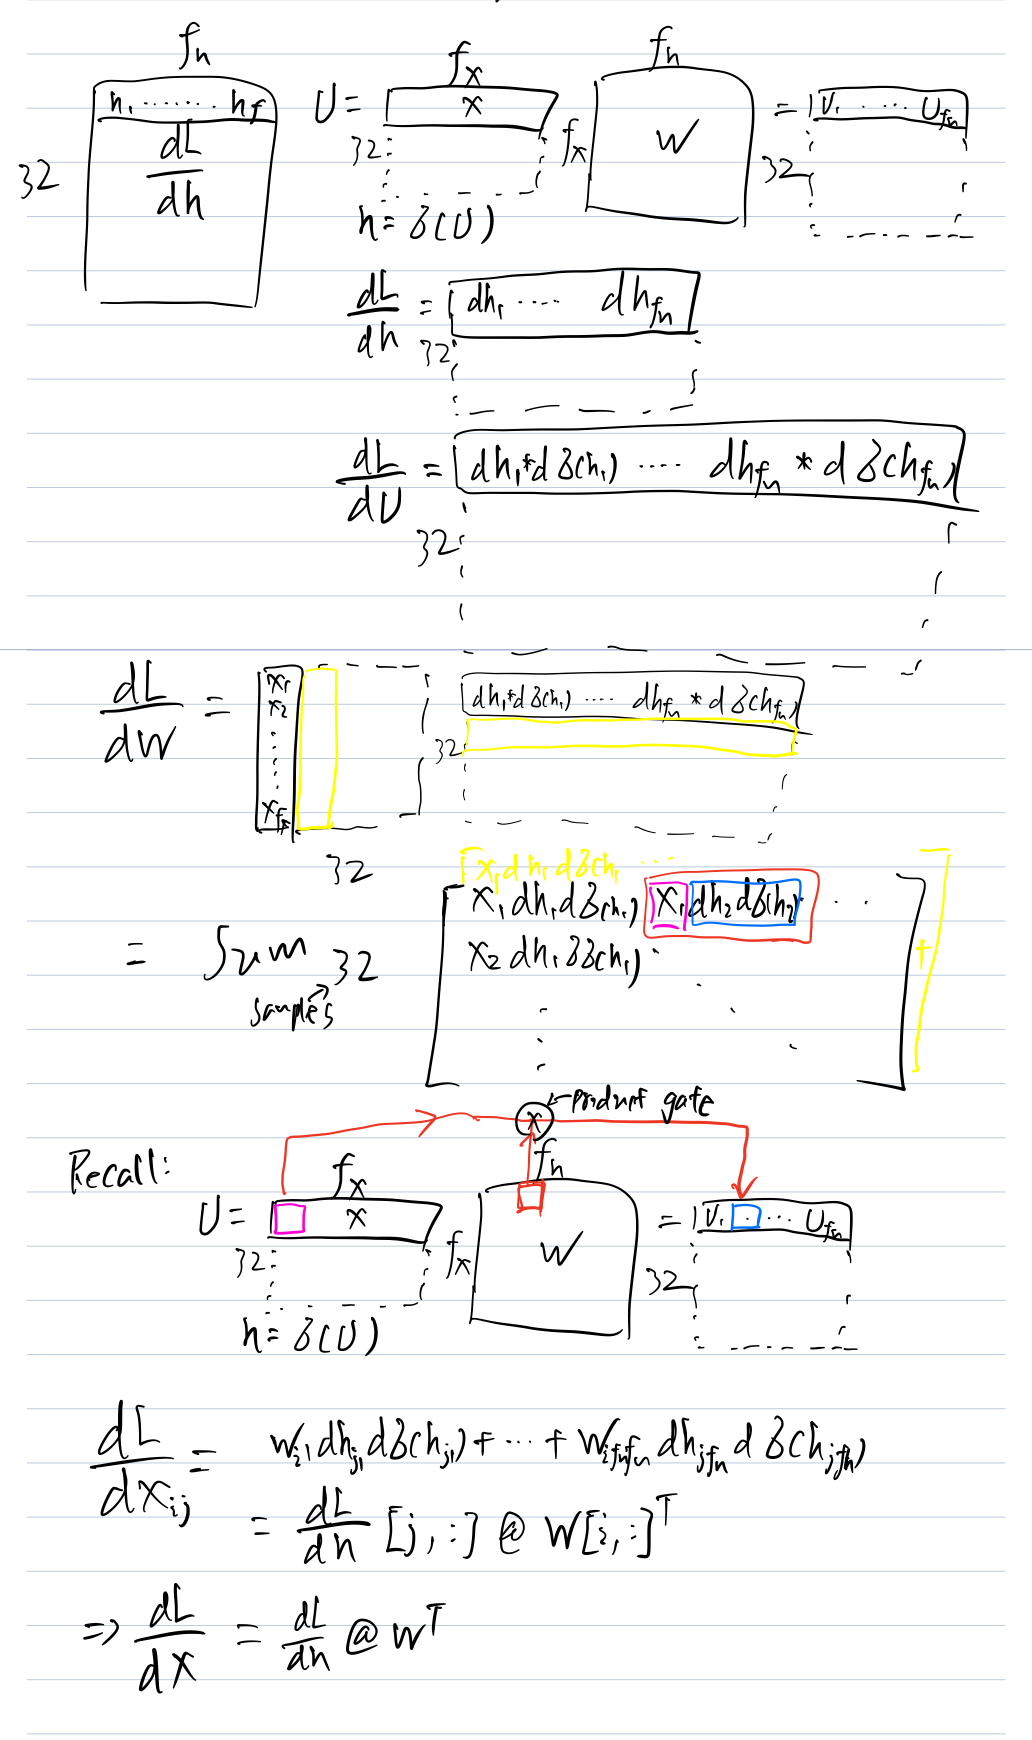

# TestingMLP: Red Wine Quality Classification Dataset

## More about the dataset:
https://archive.ics.uci.edu/ml/datasets/wine+quality

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
wine_dataset = pd.read_csv('./winequality-red.csv')

In [6]:
#Converting Labels to a Binary Classification Problem
def Convert_Labels(data):
    data.loc[:,'quality'] = np.where(data.loc[:,'quality']>=6, 1, 0)
    return data

#Scales features to constrain them to lie within the default range (0,1)
def DataScaler(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data

all_columns = list(wine_dataset)
target = ['quality']
print(all_columns)
features = list(set(all_columns)-set(target))
print(features)
wine_dataset.loc[:,features] = DataScaler(wine_dataset.loc[:,features])

wine_dataset.head()

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
['free sulfur dioxide', 'chlorides', 'residual sugar', 'citric acid', 'fixed acidity', 'alcohol', 'volatile acidity', 'pH', 'total sulfur dioxide', 'sulphates', 'density']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,5
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,5
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,6
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5


In [7]:
label_converted_dataset = Convert_Labels(wine_dataset)
print(label_converted_dataset)
#As you can see, the quality column (our labels) now has either 0 (for quality<6) and 1 (for quality>=6)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.247788          0.397260         0.00        0.068493   0.106845   
1          0.283186          0.520548         0.00        0.116438   0.143573   
2          0.283186          0.438356         0.04        0.095890   0.133556   
3          0.584071          0.109589         0.56        0.068493   0.105175   
4          0.247788          0.397260         0.00        0.068493   0.106845   
...             ...               ...          ...             ...        ...   
1594       0.141593          0.328767         0.08        0.075342   0.130217   
1595       0.115044          0.294521         0.10        0.089041   0.083472   
1596       0.150442          0.267123         0.13        0.095890   0.106845   
1597       0.115044          0.359589         0.12        0.075342   0.105175   
1598       0.123894          0.130137         0.47        0.184932   0.091820   

      free sulfur dioxide  

In [8]:
#Quick Sanity check that our dataset it indeed relatively balanced
label_converted_dataset['quality'].mean()

0.5347091932457786

In [9]:
y_wine = label_converted_dataset.loc[:,'quality']
X_wine = label_converted_dataset.drop(target,axis=1)

In [10]:
X_wine_np= np.asarray(X_wine)
y_wine_np= np.asarray(y_wine)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine_np, y_wine_np, test_size=0.25, random_state=1)

### Performance of sklearn MLP

In [11]:
wine_quality_classifier = MLPClassifier(solver='sgd',
                                            alpha=0.01, 
                                            learning_rate_init=0.001,
                                            batch_size=16,
                                            hidden_layer_sizes=(12,8,2),
                                            random_state=1,
                                            max_iter=200
                                            )

wine_quality_classifier.fit(X_wine_train, y_wine_train)

MLPClassifier(alpha=0.01, batch_size=16, hidden_layer_sizes=(12, 8, 2),
              random_state=1, solver='sgd')

In [12]:
wine_quality_classifier.score(X_wine_test, y_wine_test)

0.75

## Evaluating our MLP on the Red Wine Dataset

First, we instantiate and train a standard MLP (that uses the RELU activation function).

In [13]:
my_wine_NN_1 = NN()
num_epochs= 150
lambda_reg= 0.01
learning_rate= 0.001
batch_size= 32

In [14]:
my_wine_NN_1.add_layer('Hidden', 11, 16) #Note that the first layer's weight matrix must be 11 x k , as the input feature vector is 11-dimensional.
my_wine_NN_1.add_layer('Hidden', 16, 12)
my_wine_NN_1.add_layer('Hidden', 12, 8)
my_wine_NN_1.add_layer('Output', 8, 2)
my_wine_NN_1.add_layer('Loss', 0, 0)

the accuracy on the training data after epoch 1 is 0.53628023352794
the accuracy on the training data after epoch 2 is 0.53628023352794
the accuracy on the training data after epoch 3 is 0.5354462051709759
the accuracy on the training data after epoch 4 is 0.5354462051709759
the accuracy on the training data after epoch 5 is 0.5354462051709759
the accuracy on the training data after epoch 6 is 0.5354462051709759
the accuracy on the training data after epoch 7 is 0.5371142618849041
the accuracy on the training data after epoch 8 is 0.5371142618849041
the accuracy on the training data after epoch 9 is 0.5396163469557965
the accuracy on the training data after epoch 10 is 0.5429524603836531
the accuracy on the training data after epoch 11 is 0.5554628857381151
the accuracy on the training data after epoch 12 is 0.5821517931609674
the accuracy on the training data after epoch 13 is 0.6205170975813178
the accuracy on the training data after epoch 14 is 0.6522101751459549
the accuracy on the

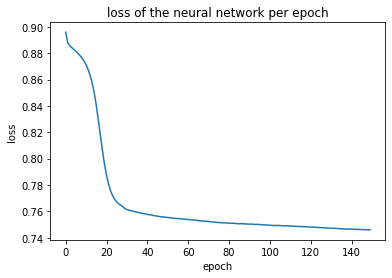

In [15]:
loss_wine_li_1= my_wine_NN_1.train(X_wine_train, y_wine_train, num_epochs, batch_size, learning_rate, lambda_reg)
plot_loss(loss_wine_li_1)

In [16]:
print(my_wine_NN_1.compute_accuracy(X_wine_test, y_wine_test))

0.74


In [44]:
my_wine_NN_2 = NN()
num_epochs= 100
lambda_reg= 0.01
learning_rate= 0.001
batch_size= 32

In [45]:
my_wine_NN_2.add_layer('Hidden', 11, 16) #Note that the first layer's weight matrix must be 11 x k , as the input feature vector is 11-dimensional.
my_wine_NN_2.add_layer('Hidden', 16, 12)
my_wine_NN_2.add_layer('Hidden_Vondrick', 12, 8)
my_wine_NN_2.add_layer('Output', 8, 2)
my_wine_NN_2.add_layer('Loss', 2, 2)

Intital Value of Vondrick Exponent: 1.8937095211455652


the accuracy on the training data after epoch 1 is 0.53628023352794
the accuracy on the training data after epoch 2 is 0.5254378648874062
the accuracy on the training data after epoch 3 is 0.5329441201000834
the accuracy on the training data after epoch 4 is 0.5371142618849041
the accuracy on the training data after epoch 5 is 0.5387823185988324
the accuracy on the training data after epoch 6 is 0.5437864887406172
the accuracy on the training data after epoch 7 is 0.5579649708090075
the accuracy on the training data after epoch 8 is 0.567139282735613
the accuracy on the training data after epoch 9 is 0.5804837364470392
the accuracy on the training data after epoch 10 is 0.6105087572977481
the accuracy on the training data after epoch 11 is 0.6413678065054211
the accuracy on the training data after epoch 12 is 0.6680567139282736
the accuracy on the training data after epoch 13 is 0.6697247706422018
the accuracy on the training data after epoch 14 is 0.6997497914929107
the accuracy on th

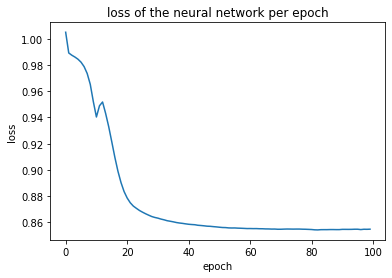

In [46]:
loss_wine_li_2= my_wine_NN_2.train(X_wine_train, y_wine_train, num_epochs, batch_size, learning_rate, lambda_reg)
plot_loss(loss_wine_li_2)

In [47]:
print(my_wine_NN_2.compute_accuracy(X_wine_test, y_wine_test))

0.755


# Acknowledgement
==================

This note is mainly based on Assignment of COMS 4732 at Columbia by Professor Carl Vondrick